In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
from sklearn.metrics import accuracy_score, log_loss,f1_score,roc_curve,roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier


In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [78]:
y = train.iloc[:,-1]
X = train.iloc[:,:-1]

X = pd.get_dummies(X,columns=['slope_of_peak_exercise_st_segment','resting_ekg_results','chest_pain_type','num_major_vessels'],drop_first=True)

In [79]:
X_t = test.copy()
X_t = pd.get_dummies(X_t,columns=['slope_of_peak_exercise_st_segment','resting_ekg_results','chest_pain_type','num_major_vessels'],drop_first=True)

In [81]:
X.nunique().sort_values()

thal_reversible_defect                    2
num_major_vessels_1                       2
chest_pain_type_4                         2
chest_pain_type_3                         2
chest_pain_type_2                         2
resting_ekg_results_2                     2
resting_ekg_results_1                     2
slope_of_peak_exercise_st_segment_3       2
slope_of_peak_exercise_st_segment_2       2
num_major_vessels_3                       2
thal_normal                               2
exercise_induced_angina                   2
sex                                       2
fasting_blood_sugar_gt_120_mg_per_dl      2
num_major_vessels_2                       2
oldpeak_eq_st_depression                 31
resting_blood_pressure                   33
age                                      40
max_heart_rate_achieved                  73
serum_cholesterol_mg_per_dl             116
dtype: int64

In [9]:
# Predicted, Actual
def metrics_summary(train_pred,y):
    print("Log Loss:",log_loss(y, train_pred));print()
    print("Accuracy:",accuracy_score(y, train_pred));print()

    #confusion matrix
    cross = pd.crosstab(train_pred,y
                        ,rownames=['Predicted'],colnames=['Actual'])
    print(cross)

## Baseline

In [102]:
clf = RandomForestClassifier(random_state=0).fit(X,y)
train_pred = clf.predict(X)
metrics_summary(train_pred,y)

Log Loss: 0.3837686243736207

Accuracy: 0.9888888888888889

Actual      0   1
Predicted        
0          99   1
1           1  79


c:\users\p s v\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


## Cross validation

In [129]:
i = 1
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True) 
# scores = []
model = RandomForestClassifier()
for train_index,test_index in kf.split(X,y):
    print('\n{} of kfold {}'.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = y[train_index],y[test_index]
    
    model = RandomForestClassifier(random_state=0,n_estimators=10,max_features=2)
    model.fit(xtr, ytr)     
    
    pred_test = model.predict(xvl)
    score = accuracy_score(yvl,pred_test)
    scores.append(score)
    print('accuracy_score',score)
    i+=1 
    
print('\nMean score',np.mean(scores))


1 of kfold 5
accuracy_score 0.7222222222222222

2 of kfold 5
accuracy_score 0.8055555555555556

3 of kfold 5
accuracy_score 0.8055555555555556

4 of kfold 5
accuracy_score 0.75

5 of kfold 5
accuracy_score 0.8055555555555556

Mean score 0.7858156028368796


In [104]:
model.feature_importances_.shape

(20,)

Index(['resting_blood_pressure', 'fasting_blood_sugar_gt_120_mg_per_dl',
       'serum_cholesterol_mg_per_dl'],
      dtype='object')


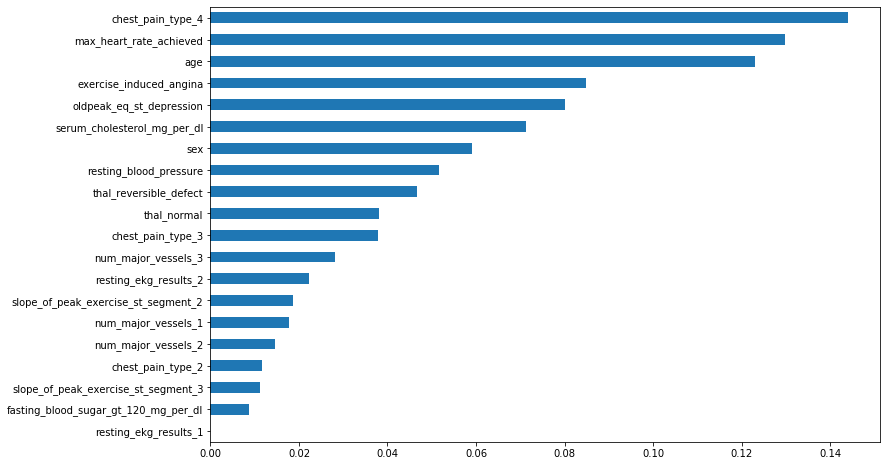

In [105]:
importances=pd.Series(model.feature_importances_, index=X.columns).sort_values()
print(X.columns[:3])
importances.plot(kind='barh', figsize=(12,8))

## Hyperparameter tuning

In [85]:
model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=True)

In [86]:
from sklearn.model_selection import GridSearchCV
weights = np.linspace(0.05, 0.95, 20)

gsc = GridSearchCV(
    # Model here
    estimator=RandomForestClassifier(random_state=0,n_estimators=100),
    param_grid = {
                    'max_features':list(range(2,14)) + [None],
#                     'max_features':[3],
                    'warm_start':[True]
                 },
    scoring='accuracy',
    cv=5,
    verbose=1
)

grid_result = gsc.fit(X, y)
print("Best parameters : %s" % grid_result.best_params_)

# Model here
clf = RandomForestClassifier(**grid_result.best_params_).fit(X, y)
train_pred = clf.predict(X)

metrics_summary(train_pred,y)

Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters : {'max_features': 2, 'warm_start': True}
Log Loss: 0.19188209108283807

Accuracy: 0.9944444444444445

Actual       0   1
Predicted         
0          100   1
1            0  79


[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    9.9s finished
c:\users\p s v\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


## Random tryout

## Submission